In [1]:
# filelist
import platform
import cv2
import numpy as np
import os
from pathlib import Path

root = os.getcwd() # Don't change this
data_dirname = '/data_test/plantvillage/' # Change as you like 
p = Path(root + data_dirname)
p.mkdir(exist_ok=True) 
if platform.system()=='Darwin':
  root = os.getcwd() # Don't change this
  data_dirname = '/data_test/plantvillage/' # Change as you like 
  p = Path(root + data_dirname)
  p.mkdir(exist_ok=True) 
#else:
#  p = Path("C:/Users/mwels/Documents/Uni/11. Semester/Deep learning in visual recognition/Plant_leave_diseases_dataset_without_augmentation")
#  p.mkdir(exist_ok=True)


classes = [
  'Apple___Apple_scab',
  'Apple___healthy',
  'Apple___Black_rot',
  'Apple___Cedar_apple_rust',
  "all"
  ]

if "all" in classes:
  classes = os.listdir(p)

for c in classes:
  print(c,end=" ")
  filelist = [x for x in (p/c).iterdir() if x.is_file()]
  for f in filelist:
    img = cv2.imread(str(f))
    if img is None:
      print(f'Failed to open {f}. Deleting file')
      os.remove(str(f))
# Pick first image of first class (i.e., cat)
# filelist = [x for x in (p/classes[0]).iterdir() if x.is_file()]
print(len(filelist))

Apple___Cedar_apple_rust Apple___Apple_scab Apple___Black_rot Apple___healthy 1645


In [2]:
from keras.layers import Dense,GlobalAveragePooling2D, Concatenate, Input, Flatten, Lambda, Layer
from keras.models import Model
from src import fenchel_young
from src import perturbations
import tensorflow as tf
#Custom ranking layer
class Ranking(Layer):
    def __init__(self, num_samples=1000000, sigma=0.1, noise='gumbel', batched=True):
        self.num_samples = num_samples
        self.sigma = sigma
        self.noise = noise
        self.batched=batched
        super(Ranking, self).__init__()

    def call(self, inputs):
        @perturbations.perturbed(num_samples=self.num_samples, sigma=self.sigma, noise=self.noise, batched=self.batched)
        def ranks_fn(x, axis=-1):
            return tf.cast(tf.argsort(tf.argsort(x, axis=axis), axis=axis), dtype=x.dtype)

        return ranks_fn(inputs)
#Split input layer
class TestL(Layer):
    def __init__(self, regularization_strength = 1):
        self.regularization_strength = regularization_strength
        super(TestL, self).__init__()

    def call(self, inputs):
        
        return tf.tensordot(inputs,tf.convert_to_tensor([1.2,2,3]),0)

2022-10-21 11:13:13.346428: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
Ranking()(Input(3))

<KerasTensor: shape=(None, 3) dtype=float32 (created by layer 'ranking')>

In [94]:
from src import fenchel_young
from src import perturbations
#import gin
#@gin.configurable
#@perturbations.perturbed(num_samples=1000000, sigma=0.5, noise='gumbel', batched=True)
def ranks_fn(x, axis=-1):
  return tf.cast(tf.argsort(tf.argsort(x, axis=axis), axis=axis), dtype=x.dtype)

print(ranks_fn(tf.convert_to_tensor([[1.,0.2,3],[0.,1,2]])))

myloss = fenchel_young.FenchelYoungLoss(ranks_fn, num_samples=1000000, sigma=0.1, noise='gumbel', batched=True)
a = tf.convert_to_tensor([[1.,2,0],[0.,1,2]])
b = tf.convert_to_tensor([[0.5,1,0.2],[0.,1,1.2]])
print(myloss(a,b).numpy())
a = tf.convert_to_tensor([[1.,2,0],[0.,1,2]])
b = tf.convert_to_tensor([[1,2,0.2],[0.,1,1.2]])
print(myloss(a,b).numpy())
a = tf.convert_to_tensor([[1.,2,0],[0.,1,2]])
b = tf.convert_to_tensor([[10,20,00],[00.,10,20]])
print(myloss(a,b).numpy())

tf.Tensor(
[[1. 0. 2.]
 [0. 1. 2.]], shape=(2, 3), dtype=float32)
0.032706544
0.02825706
0.0


In [5]:
from src.fast_soft_sort.tf_ops import soft_rank
class RankingLoss(tf.keras.losses.Loss):

    def call(self, y_true, y_pred):
        @tf.custom_gradient
        def loss(self,y_true, y_pred):
            diff = soft_rank(y_pred)-tf.cast(y_true,  dtype=y_pred.dtype)
    

            def grad(dy):
                dy = tf.reshape(dy, [tf.shape(dy)[0]] + (diff.shape.rank - 1) * [1])
                return dy*diff


            return 0.5*tf.square(diff)
        
        return self.loss(y_true, y_pred)

In [6]:
from re import L
import tensorflow as tf

out = Input(3)
print(out)
Layer = TestL(0.1)(out)
print(Layer)
end = Dense(3)(Layer)
print(end)

KerasTensor(type_spec=TensorSpec(shape=(None, 3), dtype=tf.float32, name='input_2'), name='input_2', description="created by layer 'input_2'")
KerasTensor(type_spec=TensorSpec(shape=(None, 3, 3), dtype=tf.float32, name=None), name='test_l/Tensordot:0', description="created by layer 'test_l'")
KerasTensor(type_spec=TensorSpec(shape=(None, 3, 3), dtype=tf.float32, name=None), name='dense/BiasAdd:0', description="created by layer 'dense'")


In [102]:
#Simpler model without CCN
from keras.layers import Dense,GlobalAveragePooling2D, Concatenate, Input, Flatten, Lambda, Layer, Conv2D, BatchNormalization, Activation, MaxPooling2D
from keras.models import Model
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

tilex = 2
number_of_tiles = tilex**2
tile_size = 255//tilex


tiles = Input((number_of_tiles,tile_size,tile_size,3))
layers = {}
embedds = {}

shared_conv = Conv2D(3, 3, padding="valid", kernel_initializer='he_normal')

for i in range(number_of_tiles):
#    layers[f'tile{i}'] = preprocess_input(Lambda(lambda x: x[:,i,:,:,:])(tiles))
    layers[f'tile{i}'] = Lambda(lambda x: x[:,i,:,:,:])(tiles)
#    layers[f'conv{i}'] = Conv2D(3, 3, padding="same", kernel_initializer='he_normal')(layers[f'tile{i}'])
#    layers[f'max{i}'] = MaxPooling2D(strides=(2,2))(layers[f'conv{i}'])
#    layers[f'convv{i}'] = Conv2D(3, 3, padding="valid", kernel_initializer='he_normal')(layers[f'max{i}'])
#    layers[f'maxx{i}'] = MaxPooling2D(strides=(2,2))(layers[f'convv{i}'])
#    layers[f'flat{i}'] = Flatten()(layers[f'maxx{i}'])
#    layers[f'dense{i}'] = Dense(300, activation="relu", kernel_initializer='he_normal')(layers[f'flat{i}'])
#    embedds[f'embedd{i}'] = Dense(300, activation="relu", kernel_initializer='he_normal')(layers[f'dense{i}'])

#    layers[f'flat{i}'] = Flatten()(layers[f'tile{i}'])
#    embedds[f'embedd{i}'] = Dense(10, activation="relu", kernel_initializer='he_normal')(layers[f'flat{i}'])

    layers[f'conv{i}'] = Conv2D(3, 3, padding="same", kernel_initializer='he_normal')(layers[f'tile{i}'])
    layers[f'ac{i}'] = Activation('relu')(layers[f'conv{i}'])
    layers[f'max{i}'] = MaxPooling2D(strides=(2,2))(layers[f'ac{i}'])
    embedds[f'embedd{i}'] = Flatten()(layers[f'max{i}'])


    


concatonation = Concatenate(axis=1)(list(embedds.values()))

out = Dense(40, activation="relu", kernel_initializer='he_normal')(concatonation)
# out = Dense(500, activation="relu")(out)
out = Dense(number_of_tiles, kernel_initializer='he_normal')(out)
out = Flatten()(out)
#out = Ranking()(out)
deepM = Model(inputs=tiles, outputs=concatonation)
model = Model(inputs=tiles, outputs=out)

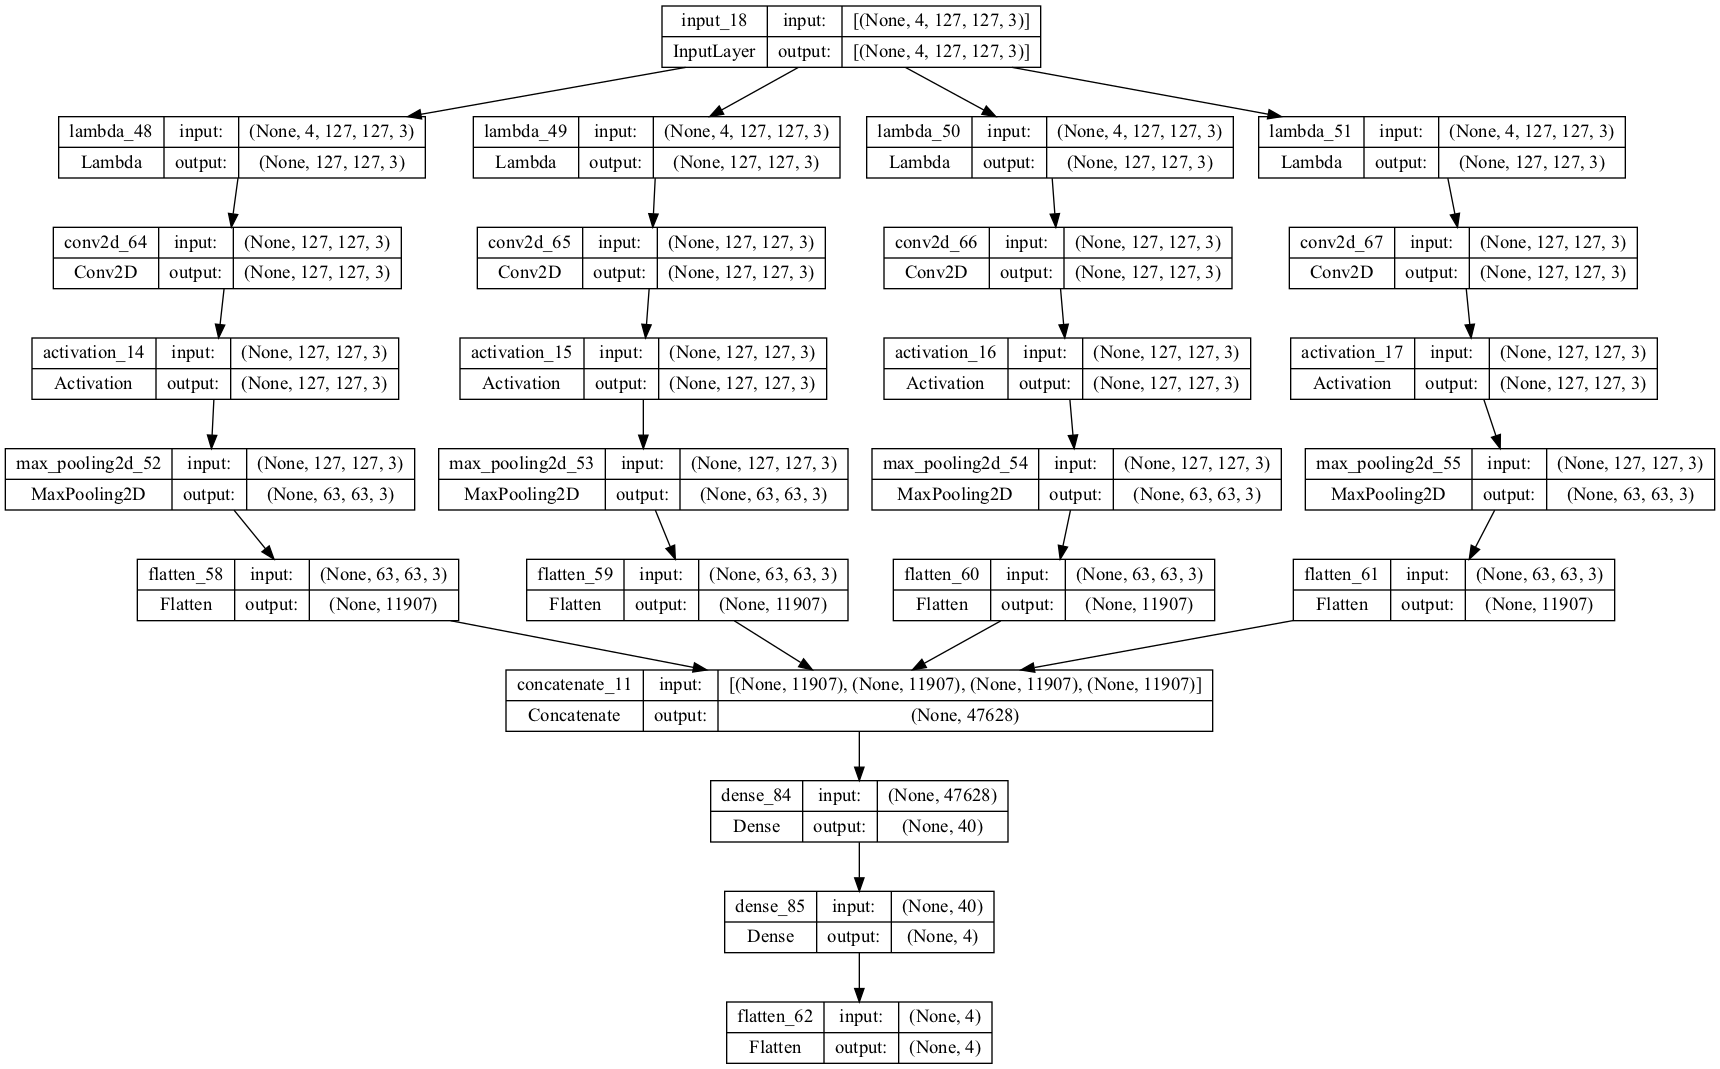

In [103]:
tf.keras.utils.plot_model(model, 
    show_shapes=True)

In [104]:
model.summary()

Model: "model_23"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_18 (InputLayer)          [(None, 4, 127, 127  0           []                               
                                , 3)]                                                             
                                                                                                  
 lambda_48 (Lambda)             (None, 127, 127, 3)  0           ['input_18[0][0]']               
                                                                                                  
 lambda_49 (Lambda)             (None, 127, 127, 3)  0           ['input_18[0][0]']               
                                                                                                  
 lambda_50 (Lambda)             (None, 127, 127, 3)  0           ['input_18[0][0]']        

In [105]:
total_num_layers = len(model.layers)
print(f"Total number of layers is {total_num_layers}")

for layer in model.layers:
    layer.trainable=True

Total number of layers is 25


In [44]:
class PartialRanksAccuracy(tf.keras.metrics.Mean):
  """This metric the proportion of matching ranks."""

  def __init__(self, name='partial_ranks_acc'):
    super().__init__(name=name)

  def update_state(self, y_true, y_pred, sample_weight=None):
    y_pred = tf.cast(ranks_fn(y_pred, axis=-1), tf.int32)
    y_true = tf.cast(y_true, tf.int32)
    equals = tf.cast(y_true == y_pred, tf.float32)
    result = tf.math.reduce_mean(equals, axis=-1)
    super().update_state(
        tf.reduce_mean(result, axis=-1), sample_weight=sample_weight)

class ProjectedRanksAccuracy(tf.keras.metrics.Mean):
  """This metric is the normalized projection onto the permutahedron."""

  def __init__(self):
    super().__init__(name='projection_ranks_acc')

  def update_state(self, y_true, y_pred, sample_weight=None):
    y_pred = tf.cast(ranks_fn(y_pred, axis=-1), tf.float32)
    y_true = tf.cast(y_true, tf.float32)
    n = tf.cast(tf.shape(y_true)[-1], tf.float32)
    max_proj = (n - 1.0) * n * (2.0 * n - 1.0) / 6.0
    result = tf.math.reduce_sum(y_true * y_pred, axis=-1) / max_proj
    super().update_state(
        tf.reduce_mean(result, axis=-1), sample_weight=sample_weight)

In [68]:
#NEW BETTER MODEL MSE
from keras import optimizers
from sklearn.model_selection import train_test_split
from src.permutation_tools import *
import tensorflow_ranking as tfr 

x_train, x_test = train_test_split(filelist)

train_generator = PermNetDataGenerator([x_train[0]]*256, 8,tilenumberx=tilex)
validation_generator = PermNetDataGenerator(x_test)


# Set up optimizer
sgd_optimizer = optimizers.SGD(learning_rate=0.001, decay=1e-6, momentum=0.9, nesterov=True)

# Compile model 
# softmax_loss = tfr.keras.losses.get(tfr.keras.losses.RankingLossKey.MEAN_SQUARED_LOSS)
model.compile(optimizer=sgd_optimizer,loss=tf.keras.losses.MeanSquaredError(), metrics=[ProjectedRanksAccuracy(), PartialRanksAccuracy()])

# Train model for 150 epochs
history = model.fit(train_generator,epochs=5)

Epoch 1/5
8/8 [==============================] - 63s 7s/step - loss: 2.3058 - projection_ranks_acc: 0.6677 - partial_ranks_acc: 0.2686
Epoch 2/5
8/8 [==============================] - 60s 7s/step - loss: 2.5538 - projection_ranks_acc: 0.6345 - partial_ranks_acc: 0.2266
Epoch 3/5
3/8 [==========>...................] - ETA: 30s - loss: 2.4167 - projection_ranks_acc: 0.6548 - partial_ranks_acc: 0.2578

KeyboardInterrupt: 

In [45]:
#NEW BETTER MODEL
from keras import optimizers
from sklearn.model_selection import train_test_split
from src.permutation_tools import *
import tensorflow_ranking as tfr 

x_train, x_test = train_test_split(filelist)

train_generator = PermNetDataGenerator([x_train[0]]*512, 32, tilenumberx=tilex)
validation_generator = PermNetDataGenerator(x_test)


# Set up optimizer
sgd_optimizer = optimizers.SGD(learning_rate=0.001, decay=1e-6, momentum=0, nesterov=False)

# Compile model 
# softmax_loss = tfr.keras.losses.get(tfr.keras.losses.RankingLossKey.MEAN_SQUARED_LOSS)
model.compile(optimizer=sgd_optimizer,loss=myloss, metrics=[ProjectedRanksAccuracy(), PartialRanksAccuracy()])

# Train model for 150 epochs
history = model.fit(train_generator,epochs=10)

Epoch 1/10
16/16 [==============================] - 92s 5s/step - loss: 208.1114 - projection_ranks_acc: 0.7208 - partial_ranks_acc: 0.3076
Epoch 2/10
16/16 [==============================] - 80s 5s/step - loss: 129.5124 - projection_ranks_acc: 0.7577 - partial_ranks_acc: 0.3433
Epoch 3/10
16/16 [==============================] - 108s 7s/step - loss: 111.9594 - projection_ranks_acc: 0.7843 - partial_ranks_acc: 0.3438
Epoch 4/10
16/16 [==============================] - 91s 6s/step - loss: 110.7152 - projection_ranks_acc: 0.7895 - partial_ranks_acc: 0.3560
Epoch 5/10
16/16 [==============================] - 96s 6s/step - loss: 107.9270 - projection_ranks_acc: 0.7895 - partial_ranks_acc: 0.3623
Epoch 6/10
16/16 [==============================] - 97s 6s/step - loss: 109.1593 - projection_ranks_acc: 0.7810 - partial_ranks_acc: 0.3433
Epoch 7/10
16/16 [==============================] - 108s 7s/step - loss: 107.7419 - projection_ranks_acc: 0.7900 - partial_ranks_acc: 0.3257
Epoch 8/10
16/16 [

KeyboardInterrupt: 

(4, 127, 127, 3)
0.10877073
[[3. 1. 0. 2.]
 [1. 0. 2. 3.]]
1/1 [==============================] - 0s 95ms/step


<tf.Tensor: shape=(2, 4), dtype=float32, numpy=
array([[1., 2., 0., 3.],
       [0., 2., 1., 3.]], dtype=float32)>

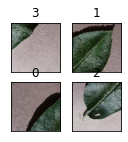

In [113]:
from src.permutation_tools import *
tesgen = PermNetDataGenerator([x_train[0]]*16, 2, tilenumberx=tilex)
X, y = tesgen.next()
print(tesgen.input_shape)
print(np.mean((X[0]-X[1])**2))
showPermImg(X[0], y[0])
print(y)
ranks_fn(model.predict(X))

In [ ]:
for layer in model.layers[]:
    

In [62]:
model.predict(X)

1/1 [==============================] - 0s 50ms/step


array([[-0.06311569, -0.05650755, -0.05804964, -0.04573683],
       [-0.06311569, -0.05650755, -0.05804964, -0.04573683]],
      dtype=float32)

In [106]:
#NEW BETTER MODEL
from keras import optimizers
from sklearn.model_selection import train_test_split
from src.permutation_tools import *
import tensorflow_ranking as tfr 

x_train, x_test = train_test_split(filelist)

train_generator = PermNetDataGenerator([x_train[0]]*128, 16, tilenumberx=tilex)
validation_generator = PermNetDataGenerator(x_test)


# Set up optimizer
sgd_optimizer = optimizers.SGD(learning_rate=0.001)

# Compile model 
# softmax_loss = tfr.keras.losses.get(tfr.keras.losses.RankingLossKey.MEAN_SQUARED_LOSS)
model.compile(optimizer=sgd_optimizer,loss=myloss, metrics=[ProjectedRanksAccuracy(), PartialRanksAccuracy()])

# Train model for 150 epochs
history = model.fit(train_generator,epochs=10)

Epoch 1/10
8/8 [==============================] - 23s 3s/step - loss: 95.7932 - projection_ranks_acc: 0.7299 - partial_ranks_acc: 0.3418
Epoch 2/10
8/8 [==============================] - 20s 3s/step - loss: 59.4597 - projection_ranks_acc: 0.8030 - partial_ranks_acc: 0.3633
Epoch 3/10
8/8 [==============================] - 21s 2s/step - loss: 60.9029 - projection_ranks_acc: 0.7762 - partial_ranks_acc: 0.4082
Epoch 4/10
8/8 [==============================] - 20s 3s/step - loss: 56.7309 - projection_ranks_acc: 0.8164 - partial_ranks_acc: 0.3750
Epoch 5/10
8/8 [==============================] - 21s 2s/step - loss: 56.8459 - projection_ranks_acc: 0.7824 - partial_ranks_acc: 0.3125
Epoch 6/10
8/8 [==============================] - 20s 2s/step - loss: 55.6040 - projection_ranks_acc: 0.7991 - partial_ranks_acc: 0.3906
Epoch 7/10
8/8 [==============================] - 20s 2s/step - loss: 55.8892 - projection_ranks_acc: 0.7779 - partial_ranks_acc: 0.3418
Epoch 8/10
8/8 [=========================

In [ ]:
from keras import optimizers
from sklearn.model_selection import train_test_split
from src.permutation_tools import *
import tensorflow_ranking as tfr 

x_train, x_test = train_test_split(filelist)

train_generator = PermNetDataGenerator(x_train)
validation_generator = PermNetDataGenerator(x_test)


# Set up optimizer
sgd_optimizer = optimizers.SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True)

# Compile model 
# softmax_loss = tfr.keras.losses.get(tfr.keras.losses.RankingLossKey.MEAN_SQUARED_LOSS)
model.compile(optimizer=sgd_optimizer,loss=tfr.keras.losses.MeanSquaredLoss(), metrics=['accuracy'])

step_size_train = train_generator.n//train_generator.batch_size # Number of mini-batches per epoch (training)
step_size_val = validation_generator.n//validation_generator.batch_size # Number of mini-batches per epoch (validation)

# Train model for 15 epochs
history = model.fit_generator(generator=train_generator,
                   validation_data=validation_generator,
                   validation_steps=step_size_val,
                   steps_per_epoch=step_size_train,
                   epochs=15)


In [ ]:
newDataGen = PermNetDataGenerator(input=x_train, batch_size=4, preprocess_func=preprocess_input)

In [ ]:
X, y = next(newDataGen)

In [ ]:
showPermImg(X[0],y[0])

In [ ]:
test_gen = PermNetDataGenerator(x_test) # never do this
X, y = next(test_gen)
model.predict(np.expand_dims(X[0], axis=0))

tensorflow_ranking.python.keras.losses.ListMLELoss